# Notebook to demonstrate the filtering process for the Pallas stream DTS data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from utils import read_fmi_meteo_obs, plot_2D_dts_colormap, histogram_match

## Reading the DTS data (xr dataset) and air temperature observations (pd dataframe)

In [2]:
file = '/Users/jpnousu/DTS_data/PROCESSED_DATA/pallas_dts_data.nc'
data = xr.open_dataset(file)

<Axes: xlabel='time'>

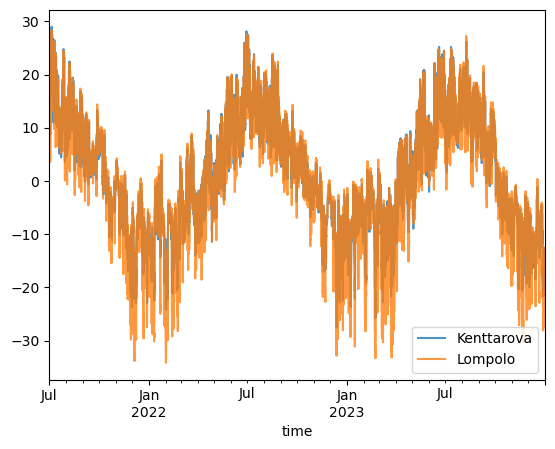

In [3]:
meteo_file1 = r'/Users/jpnousu/DTS_data/AUX_DATA/Kittilä Kenttärova_ 1.7.2021 - 31.12.2023_a4ec5682-4462-40b6-990b-ff6ca553966e.csv'
meteo_file2 = r'/Users/jpnousu/DTS_data/AUX_DATA/Kittilä Lompolonvuoma_ 1.7.2021 - 31.12.2023_583c0ede-e628-46ef-a33b-b351ff859622.csv'

meteo1 = read_fmi_meteo_obs(filename=meteo_file1, resample='30MIN')
meteo2 = read_fmi_meteo_obs(filename=meteo_file2, resample='30MIN')

meteo1 = meteo1.rename(columns={'Tair': 'Kenttarova'})
meteo2 = meteo2.rename(columns={'Tair': 'Lompolo'})
meteo1['Lompolo'] = meteo2['Lompolo']

meteo1.plot(alpha=0.8)

#### Checking for clear erroneous timesteps in DTS data

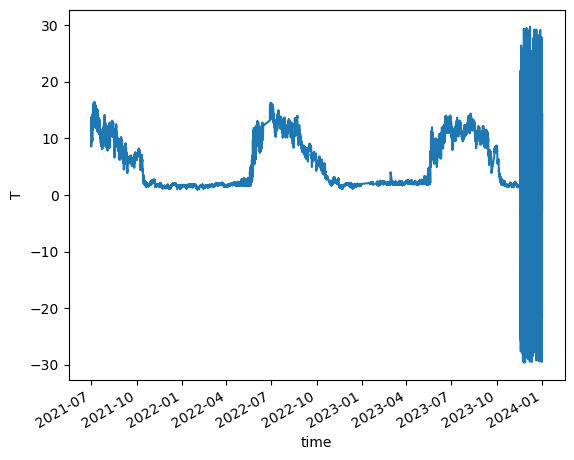

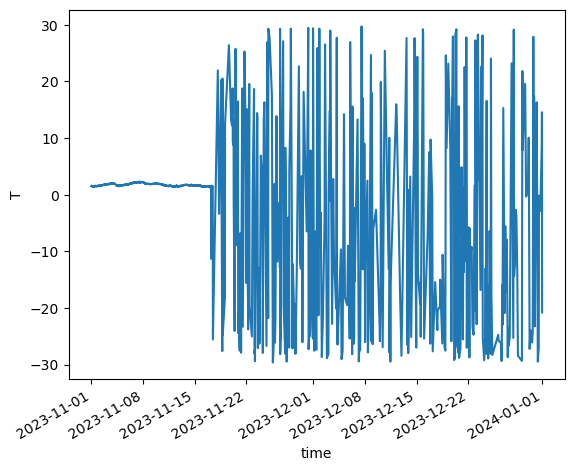

In [4]:
plt.figure(1)
data['T'].mean(dim='x').plot()
plt.figure(2)
data['T'].sel(time=slice('2023-11-01', None)).mean(dim='x').plot()

#### Removing the dates after 2023-11-15

In [5]:
data = data.sel(time=slice(None, "2023-11-15"))

## Searching where the cable is out of water
### #1 are there extreme negative sections during winter?

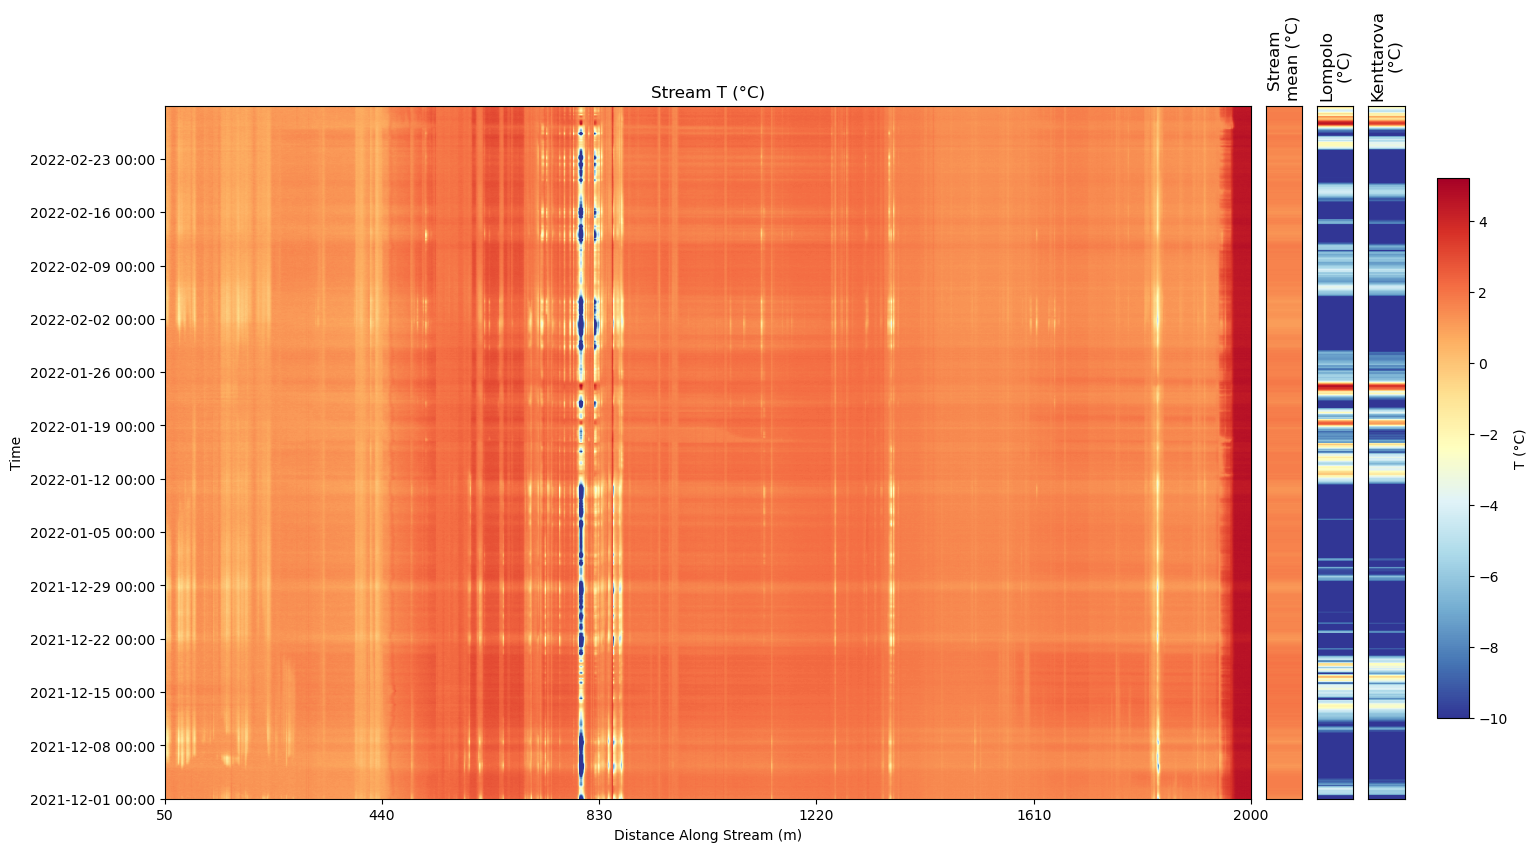

In [6]:
time_slice = slice('2021-12-01', '2022-03-01')
x_slice = slice(50, 2000)
plot_2D_dts_colormap(xr_data=data, meteo_df=meteo1, vmin=-10, time_slice=time_slice, x_slice=x_slice)

### #2 Are there sections where the summertime diurnal variation is close to observed air temperature?

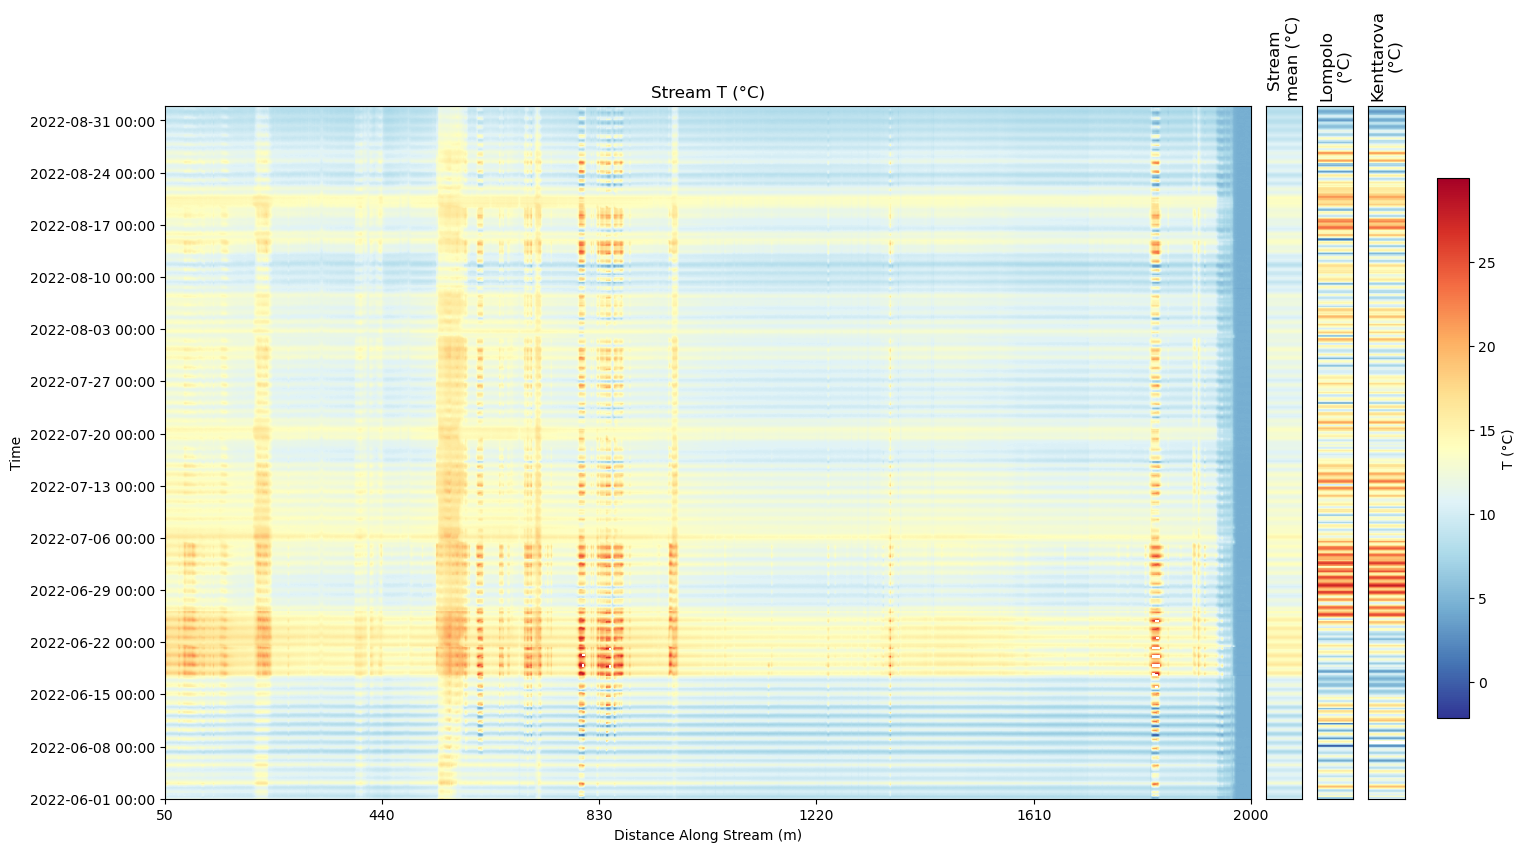

In [15]:
time_slice = slice('2022-06-01', '2022-09-01')
x_slice = slice(50, 2000)
plot_2D_dts_colormap(xr_data=data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice)

### Removing the data locations (x) where at least 5% of the data is negative

In [6]:
# Copy of the data for filtering
f_data = data.copy()

# Compute the quantile along the time dimension
quantile = data["T"].quantile(0.05, dim="time")

# Identify locations where the quantile is below 0
mask = quantile < 0

# Replace all values at those locations with NaN
f_data["T"] = data["T"].where(~mask, np.nan)

#### Plotting the same figures to see if the filtering worked

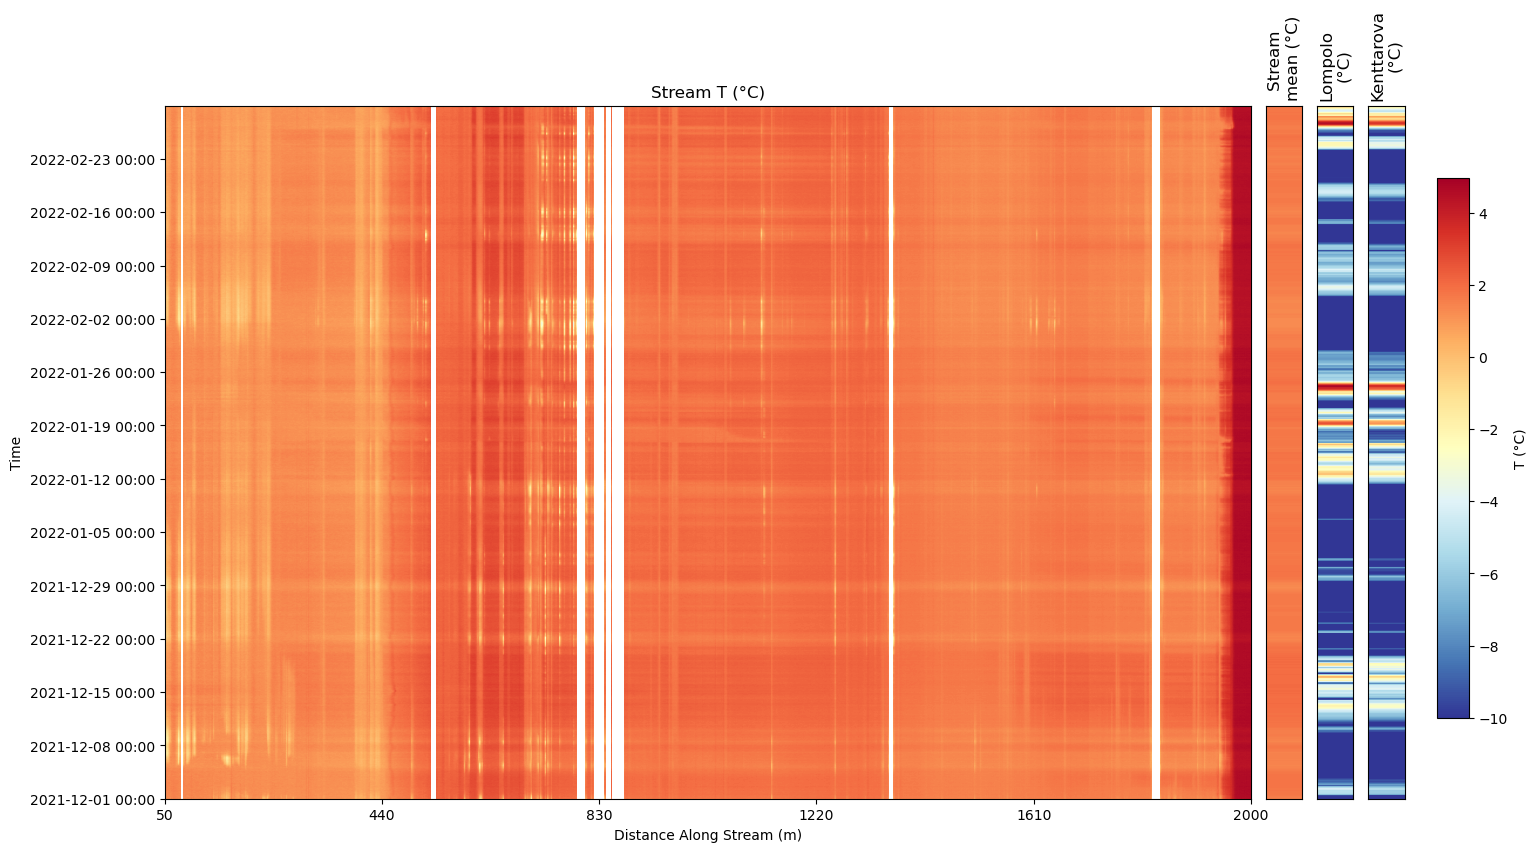

In [9]:
time_slice = slice('2021-12-01', '2022-03-01')
x_slice = slice(50, 2000)

plot_2D_dts_colormap(xr_data=f_data, meteo_df=meteo1, vmin=-10, time_slice=time_slice, x_slice=x_slice)

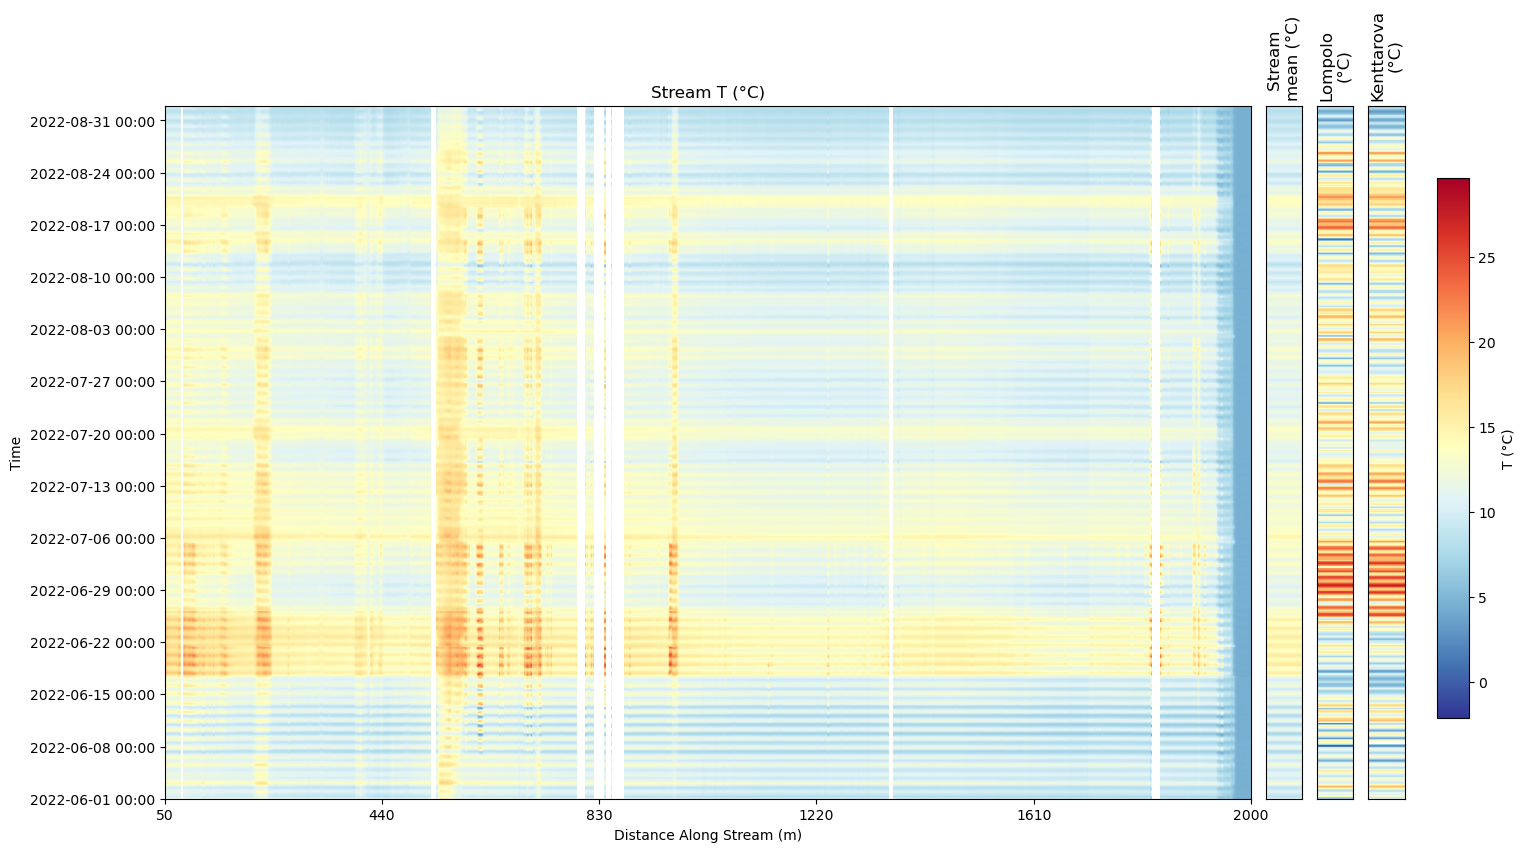

In [16]:
time_slice = slice('2022-06-01', '2022-09-01')
x_slice = slice(50, 2000)
plot_2D_dts_colormap(xr_data=f_data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice)

### Filtering worked mostly, but it seems that there are still DTS sections where summer diurnal variations are close to air temperature
#### For example here

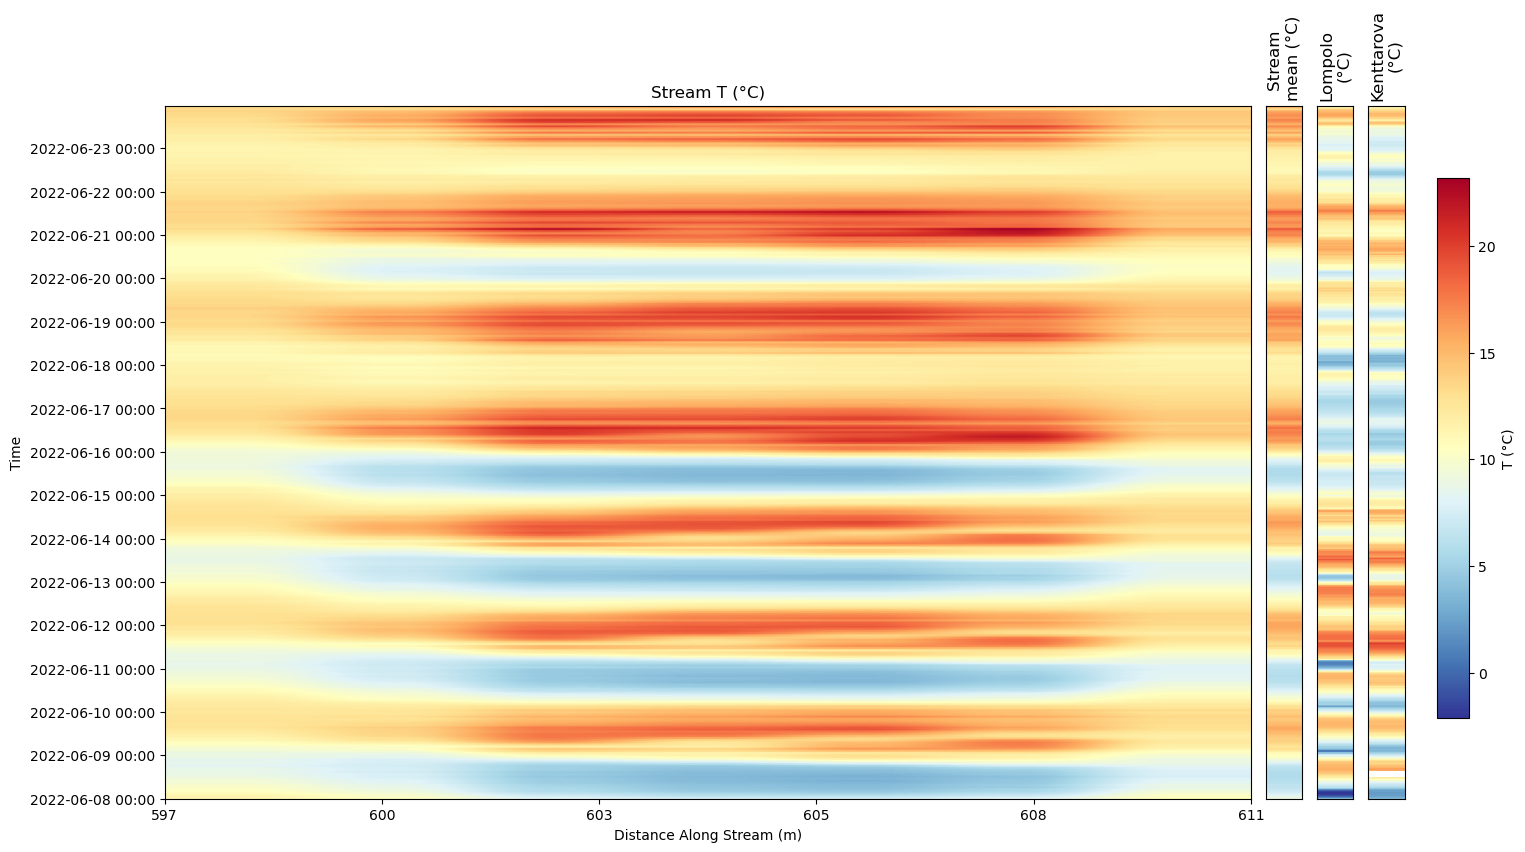

In [27]:
time_slice = slice('2022-06-08', '2022-06-23')
x_slice = slice(597, 611)
plot_2D_dts_colormap(xr_data=f_data, meteo_df=meteo1, time_slice=time_slice, x_slice=x_slice)

#### Filtering for summer months and common dates

In [68]:
f_filtered = f_data.where((f_data.time.dt.month > 5) & (f_data.time.dt.month < 9), drop=True)

# Find common times
common_times = meteo1.index.intersection(f_filtered.time.values)

# Subset both datasets to only include common times
f_filtered = f_filtered.sel(time=common_times)
meteo1_filtered = meteo1.loc[common_times]

## Distributions in summer

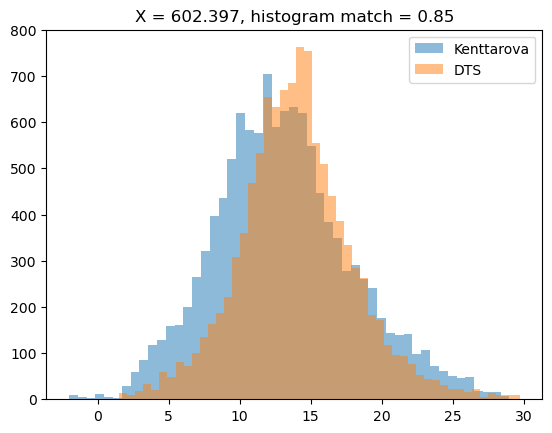

In [69]:
x_temp = 602.397

#plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Lompolo'], bins=50, alpha=0.5, label='Lompolo')
plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Kenttarova'], bins=50, alpha=0.5, label='Kenttarova')
plt.hist(f_filtered.sel(x=x_temp)['T'], bins=50, alpha=0.5, label='DTS')
hm_temp = histogram_match(np.array(f_filtered.sel(x=x_temp)['T']), np.array(meteo1_filtered['Kenttarova']), lims=[0,30])
plt.title(f'X = {x_temp}, histogram match = {hm_temp}')
plt.legend()

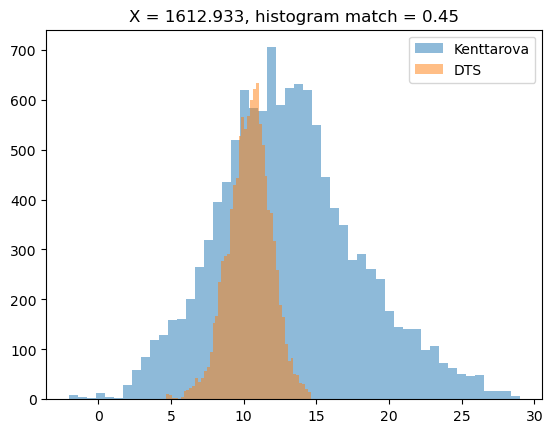

In [70]:
x_temp = 1612.933

#plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Lompolo'], bins=50, alpha=0.5, label='Lompolo')
plt.hist(meteo1.loc[(meteo1.index.month > 5) & (meteo1.index.month < 9), 'Kenttarova'], bins=50, alpha=0.5, label='Kenttarova')
plt.hist(f_filtered.sel(x=x_temp)['T'], bins=50, alpha=0.5, label='DTS')
hm_temp = histogram_match(np.array(f_filtered.sel(x=x_temp)['T']), np.array(meteo1_filtered['Kenttarova']), lims=[0,30])
plt.title(f'X = {x_temp}, histogram match = {hm_temp}')
plt.legend()

/Users/jpnousu/DTS_tools/utils.py:212: RuntimeWarning: invalid value encountered in scalar divide
  gamma = round(np.sum(minima)/np.sum(hobs),2)


Text(0.5, 0, 'Distance along stream [m]')

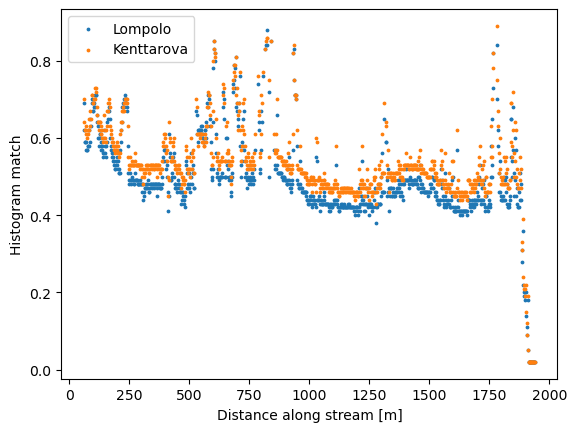

In [71]:
hm_list1 = []
hm_list2 = []
for x in f_filtered['x'].values:
    hm_temp1 = histogram_match(np.array(f_filtered.sel(x=x)['T']), np.array(meteo1_filtered['Lompolo']), lims=[0,30])
    hm_temp2 = histogram_match(np.array(f_filtered.sel(x=x)['T']), np.array(meteo1_filtered['Kenttarova']), lims=[0,30])
    hm_list1.append(hm_temp1)
    hm_list2.append(hm_temp2)

plt.scatter(f_filtered['x'].values, hm_list1, s=3, label='Lompolo')
plt.scatter(f_filtered['x'].values, hm_list2, s=3, label='Kenttarova')
plt.legend()
plt.ylabel('Histogram match')
plt.xlabel('Distance along stream [m]')